## Dictionary Learning for Denoising signals

Dictionary learning is an unsupervised learning model. It comes under the family of sparse coding models.

Sparse coding procedure/ idea for denosing:
For input signal x(t), find a latent reprsentation h(t) such that vector h(t) is sparse (has lot of 0 values) but it is possible to reconstruct original signal x(t) using h(t). [Mathematically, we minimise the reconstruction error and L1 norm.](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbjBIEyLVTsD_HySJTIhLqhUKeXjWz-SWTg_K1PxE9&s)

We can write denoised signal X as dot product of D and h(t). Here D is called Dictionary.Here we can compute dictionary with simple gradient descent methods where we compute each column of the Dictionary matrix such that it converges.


In our tutorial we will aim to denoise an audio signal and also an image.

### Audio Denoising

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction import image

In [2]:
# Load the audio file
rate, data = wavfile.read('pop.wav')

# Normalize the data
data = data / np.max(np.abs(data))

# Function to add noise
def add_noise(signal, noise_level=0.05):
    noise = np.random.randn(*signal.shape)
    noisy_signal = signal + noise_level * noise
    return noisy_signal

# Add noise to the clean signal
noisy_data = add_noise(data)

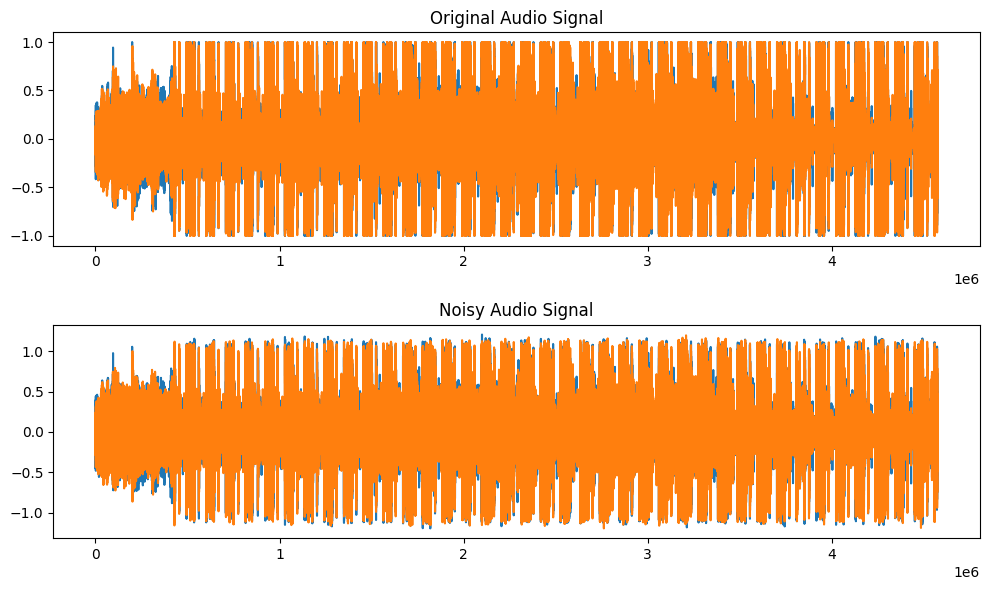

In [48]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.title("Original Audio Signal")
plt.plot(data)
plt.subplot(2, 1, 2)
plt.title("Noisy Audio Signal")
plt.plot(noisy_data)
plt.tight_layout()
plt.show()

In [49]:
# Function to extract patches
def extract_patches_1d(data, patch_size, step_size):
    patches = []
    for start in range(0, len(data) - patch_size + 1, step_size):
        end = start + patch_size
        if end > len(data):
            break
        patches.append(data[start:end])
    return np.array(patches)

### Extract patches (that is, the sparse signal)

In [64]:
# Function to reconstruct the signal from patches
def reconstruct_signal_from_patches(patches, signal_length, patch_size, step_size):
    # reconstructed_signal = np.zeros(signal_length)
    # counts = np.zeros(signal_length)

    # for i in range(len(patches)):
    #     start = i * step_size
    #     end = start + patch_size
    #     if end > signal_length:
    #         end = signal_length
    #         patch = patches[i][:signal_length - start]  # Correct the patch size to fit the remaining space
    #     else:
    #         patch = patches[i]

    #     reconstructed_signal[start:end] += patch
    #     counts[start:end] += 1

    # counts[counts == 0] = 1  # Avoid division by zero
    # reconstructed_signal /= counts
    # return reconstructed_signal
    # reconstructed_signal = np.zeros(signal_length)
    # counts = np.zeros(signal_length)

    # for i in range(patches.shape[0]):
    #     start = i * step_size
    #     end = start + patch_size

    #     patch = patches[i]

    #     reconstructed_signal[start:end] += patch

  reconstructed_signal = np.zeros(signal_length)
  num_patches = patches.shape[0]

  for i in range(num_patches):
    start = i * step_size
    end = start + patch_size

    # Handle edge cases where the patch extends beyond the signal length
    if end > signal_length:
      end = signal_length

    patch = patches[i]
    reconstructed_signal[start:end] += patch

  return reconstructed_signal

In [1]:
### Hyperparamters
patch_size = 1000
step_size = 500

In [52]:
# Extract patches
data_patches = extract_patches_1d(noisy_data, patch_size, step_size)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(


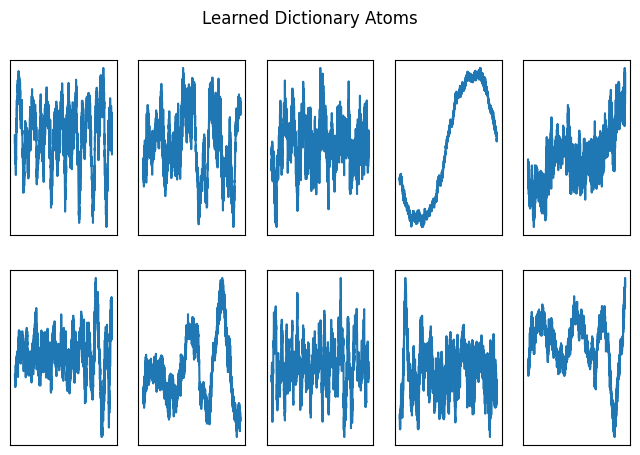

In [54]:
# Learning the dictionary in batches if necessary
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
data_patches_reshaped = data_patches.reshape(data_patches.shape[0], -1)
dico.fit(data_patches_reshaped)

# Visualizing the dictionary components
V = dico.components_
plt.figure(figsize=(8, 5))
for i, comp in enumerate(V[:10]):
    plt.subplot(2, 5, i + 1)
    plt.plot(comp)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Learned Dictionary Atoms')
plt.show()

In [55]:
transformed_patches = dico.transform(data_patches_reshaped)
reconstructed_patches = np.dot(transformed_patches, dico.components_)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size)

In [56]:
# Reshape reconstructed_patches to match the slice of reconstructed_signal
reconstructed_patches = reconstructed_patches.reshape(-1, 1)

In [63]:
reconstructed_patches.shape

(18300000, 1)

In [65]:
# Reconstruct the full signal
reconstructed_signal = reconstruct_signal_from_patches(reconstructed_patches, len(noisy_data), patch_size, step_size)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


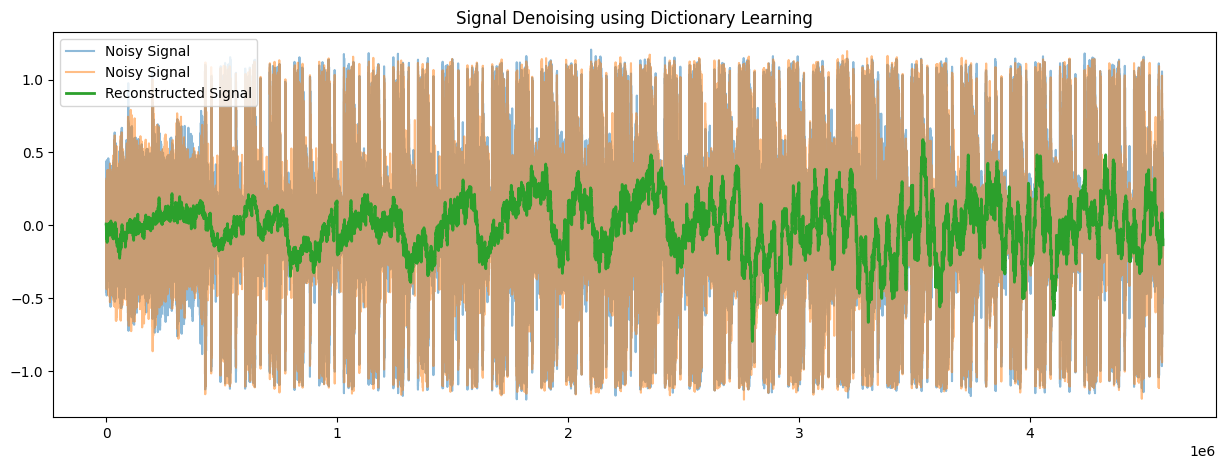

In [66]:
# Plot the original, noisy, and reconstructed signals
plt.figure(figsize=(15, 5))
plt.plot(noisy_data, label='Noisy Signal', alpha=0.5)
plt.plot(reconstructed_signal, label='Reconstructed Signal', linewidth=2)
plt.legend()
plt.title('Signal Denoising using Dictionary Learning')
plt.show()

In [67]:
from scipy.io import wavfile

In [68]:
def normalize_signal(signal):
    # Normalize signal to be within the range of int16
    abs_max = np.abs(signal).max()
    normalized_signal = signal / abs_max
    normalized_signal *= np.iinfo(np.int16).max
    return normalized_signal.astype(np.int16)

In [70]:
# Normalizing the reconstructed signal
normalized_signal = normalize_signal(reconstructed_signal)
rate = 44100
# Save the signal as a WAV file
output_filename = 'reconstructed_signal.wav'
wavfile.write(output_filename, rate, normalized_signal)

Clearly the hyperparamters need to be tuned (step size, patches, etc.) the signal is not entirely denoised.

One other thing could be that the functions to extract and reconstruct the patches were written manually, so there might be some edge case errors and to fit the operand sizes algorithm was changed a little.

### Image denoising (took inspiration from geeksforgeeks article)

In [2]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util, restoration
from sklearn.feature_extraction import image
from sklearn.decomposition import MiniBatchDictionaryLearning

In [3]:
# Replace with the path to your image file
image_path = 'lena_noisy.jpg'
noisy_image = io.imread(image_path)
noisy_image = util.img_as_float(noisy_image)
print('Noise Image shape:',noisy_image.shape)

Noise Image shape: (300, 300, 3)


In [4]:
patch_size = (7, 7)
patches = image.extract_patches_2d(noisy_image, patch_size)
print('Number of Patches :',patches.shape[0])
print('Shape of patches:',patches.shape)
# Reshape the patches for dictionary learning
data = patches.reshape(patches.shape[0], -1)
print('Shape of Input data :',data.shape)

# Perform dictionary learning
n_components = 100  # Number of dictionary atoms to learn
dl = MiniBatchDictionaryLearning(n_components=n_components,
                                 alpha=1.0,
                                 n_iter=500)
# training
dl.fit(data)

Number of Patches : 86436
Shape of patches: (86436, 7, 7, 3)
Shape of Input data : (86436, 147)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(


MiniBatchDictionaryLearning(alpha=1.0, n_components=100, n_iter=500)

In [ ]:
# Denoise the patches using the learned dictionary
denoised_patches = np.dot(dl.transform(data), dl.components_)
print('Shape of Output Denoised patches:',denoised_patches.shape)

# Reshape the denoised patches back to their original shape
denoised_patches = denoised_patches.reshape(patches.shape)
print('After Reshaping, Output Denoised patches:',denoised_patches.shape)

# Reconstruct the denoised image from the patches
reconstructed_image = image.reconstruct_from_patches_2d(denoised_patches, noisy_image.shape)
print('reconstructed_image:',reconstructed_image.shape)

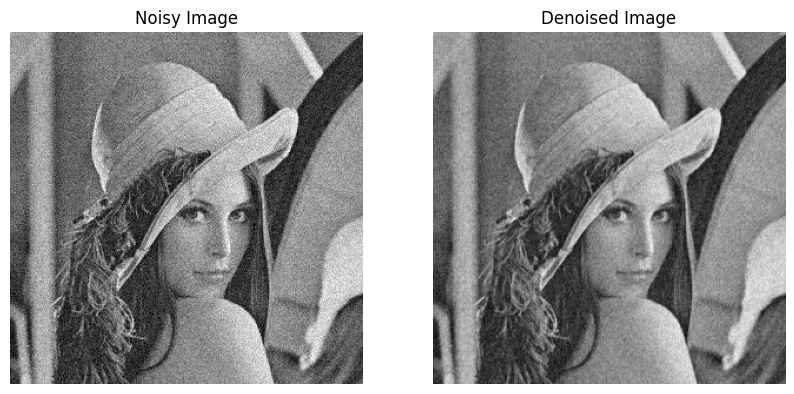

In [7]:
# Show the original noisy image and the denoised image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image)
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title('Denoised Image')
plt.axis('off')
plt.show()

Clearly the denoised image is more finer (smoother, not grainy) compared to the noisy image.